<a href="https://colab.research.google.com/github/dmaresza/PyTorch-Course/blob/main/09_PyTorch_Model_Deployment_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine, utils
    from helper_functions import download_data, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    !rm -rf going_modular/models
    !rm -rf going_modular/05*
    from going_modular.going_modular import data_setup, engine, utils
    from helper_functions import download_data, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 46.76 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x784dfc917d90>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

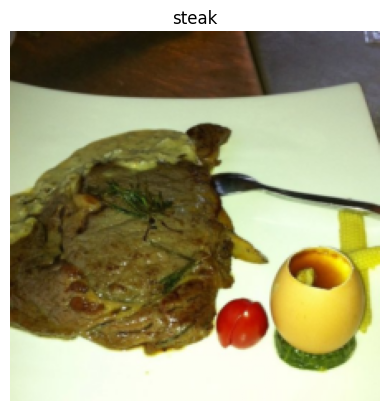

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [10]:
def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms, and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  #4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )

  return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 97.6MB/s]


In [12]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [13]:
# Loss function
loss_fn_effnetb2 = nn.CrossEntropyLoss()

# Optimizer
optimizer_effnetb2 = torch.optim.Adam(params=effnetb2.parameters(),
                                      lr=0.001)

# Training function (engine.py)
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer_effnetb2,
                                loss_fn=loss_fn_effnetb2,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9602 | train_acc: 0.6000 | test_loss: 0.7508 | test_acc: 0.9199
Epoch: 2 | train_loss: 0.6989 | train_acc: 0.8396 | test_loss: 0.5793 | test_acc: 0.9506
Epoch: 3 | train_loss: 0.6099 | train_acc: 0.8146 | test_loss: 0.5055 | test_acc: 0.9597
Epoch: 4 | train_loss: 0.4874 | train_acc: 0.8667 | test_loss: 0.4590 | test_acc: 0.9261
Epoch: 5 | train_loss: 0.5051 | train_acc: 0.8292 | test_loss: 0.3985 | test_acc: 0.9409
Epoch: 6 | train_loss: 0.3857 | train_acc: 0.9104 | test_loss: 0.3950 | test_acc: 0.9534
Epoch: 7 | train_loss: 0.4019 | train_acc: 0.8708 | test_loss: 0.3386 | test_acc: 0.9659
Epoch: 8 | train_loss: 0.3583 | train_acc: 0.8917 | test_loss: 0.3178 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.3135 | train_acc: 0.9417 | test_loss: 0.3112 | test_acc: 0.9472
Epoch: 10 | train_loss: 0.3756 | train_acc: 0.8833 | test_loss: 0.2941 | test_acc: 0.9688


In [14]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs
  torch.manual_seed(seed)
  model.heads = nn.Sequential(
      nn.Linear(in_features=768,
                out_features=num_classes)
  )

  return model, transforms

In [15]:
vit, vit_transforms = create_vit_model()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 217MB/s]


In [16]:
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [17]:
# Set up optimizer
optimizer_vit = torch.optim.Adam(params=vit.parameters(),
                                 lr=0.001)

# Set up loss function
loss_fn_vit = nn.CrossEntropyLoss()

# Train ViT feature extractor
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           optimizer=optimizer_vit,
                           loss_fn=loss_fn_vit,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5947 | train_acc: 0.8063 | test_loss: 0.2576 | test_acc: 0.9443
Epoch: 2 | train_loss: 0.2045 | train_acc: 0.9417 | test_loss: 0.1342 | test_acc: 0.9722
Epoch: 3 | train_loss: 0.1816 | train_acc: 0.9229 | test_loss: 0.1066 | test_acc: 0.9784
Epoch: 4 | train_loss: 0.1603 | train_acc: 0.9625 | test_loss: 0.1037 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1067 | train_acc: 0.9708 | test_loss: 0.0974 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0914 | train_acc: 0.9750 | test_loss: 0.0854 | test_acc: 0.9784
Epoch: 7 | train_loss: 0.1316 | train_acc: 0.9479 | test_loss: 0.0801 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.0738 | train_acc: 0.9854 | test_loss: 0.0851 | test_acc: 0.9784
Epoch: 9 | train_loss: 0.0802 | train_acc: 0.9917 | test_loss: 0.0786 | test_acc: 0.9659
Epoch: 10 | train_loss: 0.0579 | train_acc: 0.9917 | test_loss: 0.0712 | test_acc: 0.9659


In [18]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/129666.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/204151.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1001116.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3785667.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/648055.jpg')]

In [19]:
import pathlib
from typing import List, Dict
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

# 1. Create a function that takes a list of paths and a trained PyTorch model, a series of transforms, a list of target class names, and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str="cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # 2. Create an empty list (can return a full list of all predictions later).
  pred_list = []

  # 3. Loop through the target input paths (the rest of the steps will take place inside the loop).
  for path in tqdm(paths):
    # 4. Create an empty dictionary for each sample (prediction statistics will go in here).
    pred_dict = {}

    # 5. Get the sample path and ground truth class from the filepath.
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer.
    start_time = timer()

    # 7. Open the image using Image.open(path).
    img = Image.open(path)

    # 8. Transform the image to be useable with a given model (also add a batch dimension and send to target device).
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare the model for inference by sending to the target device and turning on eval() mode.
    model = model.to(device)
    model.eval()

    # 10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and preform forward pass + calculate pred prob + pred class.
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probability into prediction label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)

      # 11. Add the pred prob + pred class to empty dictionary from step 4.
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time - start_time, 4)

    # 13. See if the predicted class matches the ground truth class.
    pred_dict["correct"] = (class_name == pred_class)

    # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
    pred_list.append(pred_dict)

  # 15. Return the list of prediction dictionaries.
  return pred_list

In [20]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cuda") # hardcode predictions to happen on GPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [21]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cuda") # hardcode predictions to happen on GPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [22]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)

# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

EffNetB2 average time per prediction: 0.0283
ViT average time per prediction: 0.0137


Changing the device so that both models used the GPU to predict on the test images showed significant improvements for both models. On the CPU, the EffNetB2 model took ~0.11 seconds to predict on each image, while the ViT model took ~0.4 seconds per image. On the GPU, both models are now averaging ~0.01-0.03 seconds per prediction; a ~4x improvement for EffNetB2 and over 20x improvement for ViT. So it seems that using the GPU **DOES** make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times, and even a little bit better.

## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [23]:
vit_food101, vit_transforms = create_vit_model(num_classes=101)

In [24]:
# Create training data transforms
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms])
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [25]:
from torchvision import datasets

# Set up data directory
data_dir = Path("data")

train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms, # apply data augmentation to training data
                              download=True)

# Get the testing data(~250 images x 101 classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_transforms, # don't perform data augmentation on the test data
                             download=True)

100%|██████████| 4996278331/4996278331 [03:39<00:00, 22717543.85it/s]


Extracting data/food-101.tar.gz to data


In [26]:
from torch.utils.data import random_split # https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  # Create split lengths based on original dataset length
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1 # remaining length

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

  # Create splits with given random seed
  random_split_1, random_split_2 = random_split(dataset,
                                               lengths=[length_1, length_2],
                                               generator=torch.manual_seed(seed))

  return random_split_1, random_split_2

In [27]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                  split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


(15150, 5050)

In [28]:
import os

NUM_WORKERS = os.cpu_count()

BATCH_SIZE = 512 # Using Colab PRO, so now have a GPU with more memory

# Create Food101 20% training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20% testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(60, 20)

In [29]:
# Set up optimizer
optimizer = torch.optim.Adam(params=vit_food101.parameters(),
                             lr=0.001)

# Set up loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's result of 56.4% accuracy on the test dataset with 20% of the data
vit_food101_results = engine.train(model=vit_food101,
                                   train_dataloader=train_dataloader_food101_20_percent,
                                   test_dataloader=test_dataloader_food101_20_percent,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=5,
                                   device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4100 | train_acc: 0.3194 | test_loss: 2.4587 | test_acc: 0.5520
Epoch: 2 | train_loss: 2.5278 | train_acc: 0.5208 | test_loss: 2.1539 | test_acc: 0.6117
Epoch: 3 | train_loss: 2.3202 | train_acc: 0.5744 | test_loss: 2.0380 | test_acc: 0.6382
Epoch: 4 | train_loss: 2.1980 | train_acc: 0.6057 | test_loss: 1.9691 | test_acc: 0.6631
Epoch: 5 | train_loss: 2.1094 | train_acc: 0.6372 | test_loss: 1.9269 | test_acc: 0.6723


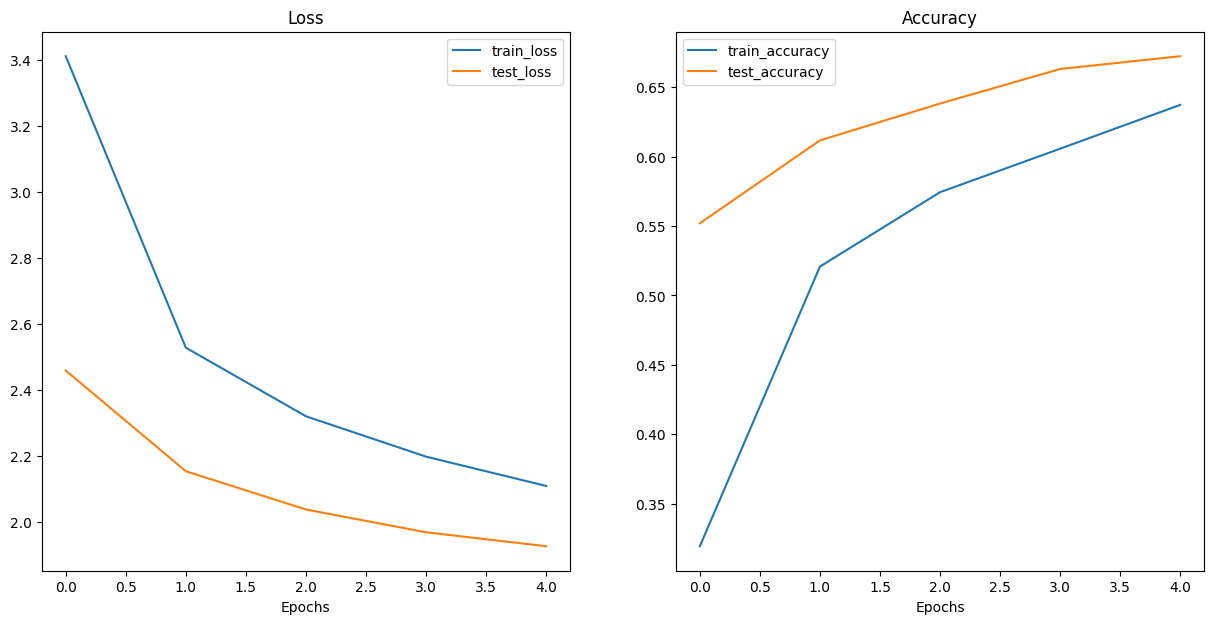

In [30]:
plot_loss_curves(vit_food101_results)

The EffNetB2 model, when it was trained on 20% of the Food101 dataset, achieved a test accuracy of ~58% after 5 epochs. This ViT model achieves a ~67% test accuracy on 20% of the Food101 dataset after 5 epochs, which is significantly better than the EffNetB2 model! It also surpasses the 56.4% accuracy from the [original Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf), which used a CNN.

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [31]:
test_dataloader_food101_20_percent_pred = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                      batch_size=1,
                                                                      shuffle=False,
                                                                      num_workers=NUM_WORKERS)

In [32]:
vit_food101_pred_list = []

vit_food101.eval()
for X, y in tqdm(test_dataloader_food101_20_percent_pred):
  X, y = X.to(device), y.to(device)
  pred_dict = {}
  with torch.inference_mode():
    pred_logit = vit_food101(X)
    pred_prob = torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_prob).cpu().numpy()
    pred_dict["pred_class"] = train_data.classes[pred_label.cpu().numpy()[0]]
    pred_dict["real_class"] = train_data.classes[y.cpu().numpy()[0]]
    pred_dict["correct"] = (y.cpu().numpy()[0] == pred_label.cpu().numpy()[0])

  vit_food101_pred_list.append(pred_dict)

vit_food101_test_pred_df = pd.DataFrame(vit_food101_pred_list)
vit_food101_test_pred_df[vit_food101_test_pred_df["correct"] == False].sort_values("pred_prob", ascending=False)[:10]

  0%|          | 0/5050 [00:00<?, ?it/s]

,pred_prob,pred_class,real_class,correct
3107,0.97607666,gyoza,dumplings,False
2848,0.8357236,french_onion_soup,bread_pudding,False
2287,0.8159047,fish_and_chips,croque_madame,False
1726,0.81022274,onion_rings,fried_calamari,False
3833,0.79666907,hamburger,poutine,False
2894,0.7748884,hamburger,falafel,False
4969,0.77399683,croque_madame,huevos_rancheros,False
230,0.7733268,falafel,poutine,False
1872,0.7596064,prime_rib,filet_mignon,False
3209,0.759085,breakfast_burrito,falafel,False


It seems that many of the wrong predictions are very similar foods. Prime rib and filet mignon are both meat/steak based foods, gyoza and dumplings are pretty much the same thing, and onion rings and fried calamari are also very visually similar.

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [33]:
vit_food101_full, vit_transforms = create_vit_model(num_classes=101)

In [34]:
BATCH_SIZE = 512 # Bigger than 32 to make better use of GPU memory

train_dataloader_food101 = torch.utils.data.DataLoader(dataset=train_data,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True,
                                                       num_workers=NUM_WORKERS)

test_dataloader_food101 = torch.utils.data.DataLoader(dataset=test_data,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=False,
                                                      num_workers=NUM_WORKERS)

len(train_dataloader_food101), len(test_dataloader_food101)

(592, 198)

In [35]:
# Set up optimizer
optimizer = torch.optim.Adam(params=vit_food101_full.parameters(),
                             lr=0.001)

# Set up loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

vit_food101_full_results = engine.train(model=vit_food101_full,
                                        train_dataloader=train_dataloader_food101,
                                        test_dataloader=test_dataloader_food101,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4800 | train_acc: 0.5285 | test_loss: 1.8233 | test_acc: 0.7108
Epoch: 2 | train_loss: 2.0805 | train_acc: 0.6393 | test_loss: 1.7224 | test_acc: 0.7441
Epoch: 3 | train_loss: 1.9960 | train_acc: 0.6643 | test_loss: 1.6918 | test_acc: 0.7529
Epoch: 4 | train_loss: 1.9447 | train_acc: 0.6810 | test_loss: 1.6600 | test_acc: 0.7620
Epoch: 5 | train_loss: 1.9162 | train_acc: 0.6921 | test_loss: 1.6524 | test_acc: 0.7657


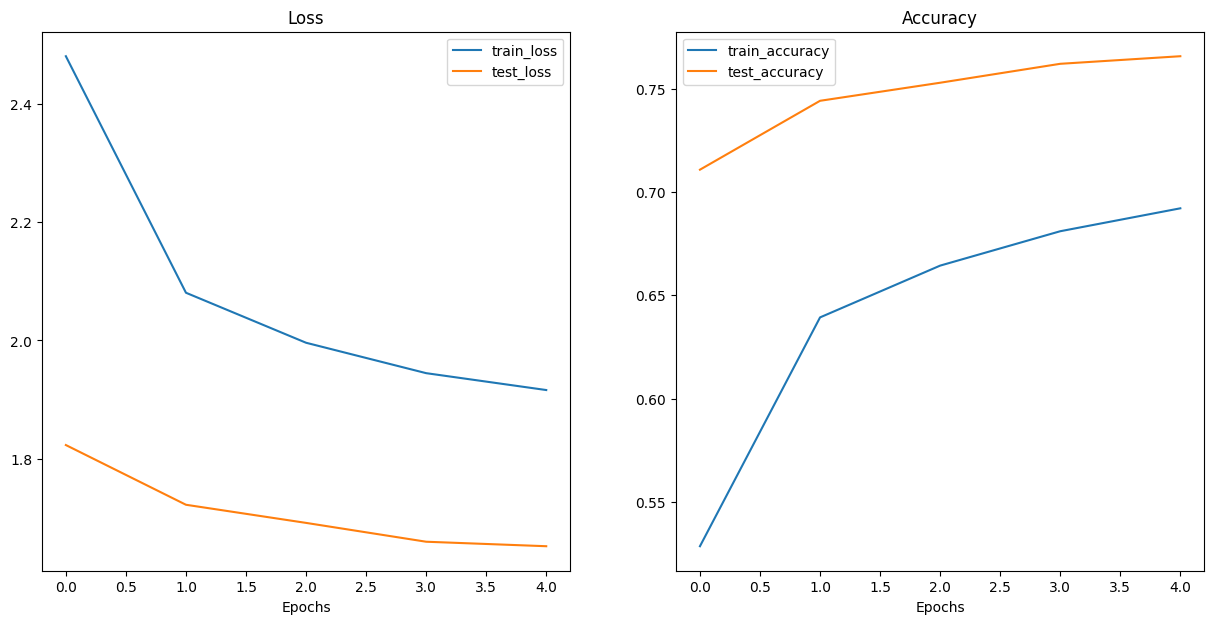

In [36]:
plot_loss_curves(vit_food101_full_results)

Although the model took nearly an hour to train, it achieved a 76% test accuracy after 5 epochs! This is better than the 67% accuracy achieved on the 20% dataset, and it looks like if the model had trained for longer the accuracy could have improved even more.

## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

I found two separate benchmarks, and I am not quite sure what the difference between them is.

It seems that for "fine-grained image classification", the current best performing model on the Food101 dataset is a model called [CAP (context-aware attentional pooling)](https://paperswithcode.com/paper/context-aware-attentional-pooling-cap-for), which achieves an astounding 98.6% accuracy.

For "image classification", the current best model seems to be [Bamboo](https://paperswithcode.com/paper/bamboo-building-mega-scale-vision-dataset). After trying to read and understand the Bamboo research paper, it seems that Bamboo is actually a *dataset* and not an actual model. It seems that the same Vision Transformer model I used (ViT-B/16) was pretrained on the Bamboo dataset, and then achieved a 92.9% accuracy on the Food101 dataset.

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

If someone tried to upload an image that wasn't food to [this FoodVision Big model](https://huggingface.co/spaces/dmaresza/foodvision_big), or tried to upload an image of food that wasn't from one of the 101 categories in the Food101 dataset, the model would still try to predict on the image as if it **was** in one of the categories, since that is all the model "knows". A possible solution to this problem would be to add a 102nd category to the dataset; maybe something like "other". This category could be a combination of food images that don't belong in any of the other categories and/or non-food images. If the model was re-trained on this new dataset, it would hopefully be able to accurately determine whether or not an image was in one of the original 101 food categories or if it belonged in the "other" category.

Another failure point could possibly happen if there were multiple different foods in one image. In such a case, the model could either predict one of the foods but miss the other, or predict something completely different if it became "confused". A possible solution would be to use a different model capable of object detection to distinguish between the two separate types of food.

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the models we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

I decided to use the same ViT model, but I'll be training it on the Oxford Flowers-102 dataset instead of Food101.

In [37]:
vit_flowers, vit_transforms = create_vit_model(num_classes=102)

In [38]:
from torchvision import datasets
from pathlib import Path

data_dir = Path("data")

train_data_flowers = datasets.Flowers102(root=data_dir,
                                         split="train",
                                         transform=vit_transforms,
                                         download=True)

val_data_flowers = datasets.Flowers102(root=data_dir,
                                       split="val",
                                       transform=vit_transforms,
                                       download=True)

test_data_flowers = datasets.Flowers102(root=data_dir,
                                        split="test",
                                        transform=vit_transforms,
                                        download=True)

len(train_data_flowers), len(val_data_flowers), len(test_data_flowers)

100%|██████████| 344862509/344862509 [00:16<00:00, 21455249.36it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 699980.26it/s]


100%|██████████| 14989/14989 [00:00<00:00, 18828518.32it/s]


(1020, 1020, 6149)

In [50]:
import os

BATCH_SIZE = 512
NUM_WORKERS = os.cpu_count()

train_dataloader_flowers = torch.utils.data.DataLoader(dataset=train_data_flowers,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True,
                                                       num_workers=NUM_WORKERS)

val_dataloader_flowers = torch.utils.data.DataLoader(dataset=val_data_flowers,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     num_workers=NUM_WORKERS)

test_dataloader_flowers = torch.utils.data.DataLoader(dataset=test_data_flowers,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=False,
                                                      num_workers=NUM_WORKERS)

len(train_dataloader_flowers), len(val_dataloader_flowers), len(test_dataloader_flowers)

(2, 2, 13)

In [51]:
# Set up optimizer
optimizer = torch.optim.Adam(params=vit_flowers.parameters(),
                             lr=0.001)

# Set up loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 paper's result of 56.4% accuracy on the test dataset with 20% of the data
vit_flowers_results = engine.train(model=vit_flowers,
                                   train_dataloader=train_dataloader_flowers,
                                   test_dataloader=val_dataloader_flowers,
                                   optimizer=optimizer,
                                   loss_fn=loss_fn,
                                   epochs=5,
                                   device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9127 | train_acc: 0.9323 | test_loss: 2.2954 | test_acc: 0.7529
Epoch: 2 | train_loss: 1.7764 | train_acc: 0.9510 | test_loss: 2.2042 | test_acc: 0.7833
Epoch: 3 | train_loss: 1.6673 | train_acc: 0.9628 | test_loss: 2.1238 | test_acc: 0.7951
Epoch: 4 | train_loss: 1.5752 | train_acc: 0.9677 | test_loss: 2.0526 | test_acc: 0.8000
Epoch: 5 | train_loss: 1.4962 | train_acc: 0.9706 | test_loss: 1.9887 | test_acc: 0.8020


In [52]:
from going_modular.going_modular import utils

vit_flowers_model_path = "pretrained_vit_feature_extractor_flowers102.pth"

utils.save_model(model=vit_flowers,
                 target_dir="models",
                 model_name=vit_flowers_model_path)

[INFO] Saving model to: models/pretrained_vit_feature_extractor_flowers102.pth


In [53]:
import shutil

flowers_demo_path = Path("demos/flowers102/")

if flowers_demo_path.exists():
  shutil.rmtree(flowers_demo_path)
  flowers_demo_path.mkdir(parents=True, exist_ok=True)
else:
  flowers_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/flowers102/

In [54]:
# Get the NAMES of the flowers, since the dataset only has labels as numbers
!wget https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
!mv Oxford-102_Flower_dataset_labels.txt demos/flowers102/class_names.txt

!mv models/pretrained_vit_feature_extractor_flowers102.pth demos/flowers102

--2024-06-25 16:56:03--  https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘Oxford-102_Flower_dataset_labels.txt’

Oxford-102_Flower_d 100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-06-25 16:56:03 (34.9 MB/s) - ‘Oxford-102_Flower_dataset_labels.txt’ saved [1608/1608]



In [55]:
flowers_demo_examples_path = flowers_demo_path / "examples"
flowers_demo_examples_path.mkdir(parents=True, exist_ok=True)

flower_examples = [Path('data/flowers-102/jpg/image_00001.jpg'),
                   Path('data/flowers-102/jpg/image_08008.jpg'),
                   Path('data/flowers-102/jpg/image_01120.jpg')]

for example in flower_examples:
  destination = flowers_demo_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copying data/flowers-102/jpg/image_00001.jpg to demos/flowers102/examples/image_00001.jpg
[INFO] Copying data/flowers-102/jpg/image_08008.jpg to demos/flowers102/examples/image_08008.jpg
[INFO] Copying data/flowers-102/jpg/image_01120.jpg to demos/flowers102/examples/image_01120.jpg


In [56]:
%%writefile demos/flowers102/model.py
import torch
import torchvision
from torch import nn

def create_vit_model(num_classes:int=3,
                     seed:int=42):
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs
  model.heads = nn.Sequential(
      nn.Linear(in_features=768,
                out_features=num_classes)
  )

  return model, transforms

Writing demos/flowers102/model.py


In [57]:
%%writefile demos/flowers102/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_vit_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:
  class_names = [flower_name.strip() for flower_name in f.readlines()]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
vit, vit_transforms = create_vit_model(
    num_classes=len(class_names), # len(class_names) would also work
)

# Load saved weights
vit.load_state_dict(
    torch.load(
        f="pretrained_vit_feature_extractor_flowers102.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = vit_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    vit.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(vit(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Flowers102"
description = "A Vision Transformer(ViT) feature extractor computer vision model to classify images of flowers in the Flowers102 dataset."
article = "Created at [09. PyTorch Model Deployment Exercises](https://github.com/dmaresza/PyTorch-Course/blob/main/09_PyTorch_Model_Deployment_Exercises.ipynb)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/flowers102/app.py


In [58]:
%%writefile demos/flowers102/requirements.txt
torch==2.3.0
torchvision==0.18.0
gradio==4.36.1

Writing demos/flowers102/requirements.txt


In [59]:
# Change into the flowers102 directory and then zip it from the inside
!cd demos/flowers102 && zip -r ../flowers102.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 57%)
  adding: class_names.txt (deflated 53%)
  adding: examples/ (stored 0%)
  adding: examples/image_01120.jpg (deflated 1%)
  adding: examples/image_00001.jpg (deflated 0%)
  adding: examples/image_08008.jpg (deflated 1%)
  adding: model.py (deflated 47%)
  adding: pretrained_vit_feature_extractor_flowers102.pth (deflated 7%)
  adding: requirements.txt (deflated 4%)


In [60]:
# Download
try:
  from google.colab import files
  files.download("demos/flowers102.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download flowers102.zip manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>